In [1]:
import pandas as pd 
import os 
import pathlib 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

##### general settings
output_version = "20250604"
umt_distance = 1

maindir = "/workdir/outdir/UMI_FROM_R1_ONLY"
path_to_main_output = f"/workdir/outdir/{output_version}/SampleSheet_UMI_runs/UMT_DISTANCE_{umt_distance}/data_analysis"
os.system(f"mkdir -p {path_to_main_output}")

path_to_02_output = os.path.join(path_to_main_output, "02_output")
os.system(f"mkdir -p {path_to_02_output}")

all_umi_files = [item for item in pathlib.Path(maindir).glob("*.txt")]

all_potential_umis = [f"{a}{s}{d}{f}{g}{h}" for a in "ACGT" for s in "ACGT" for d in "ACGT" for f in "ACGT" for g in "ACGT" for h in "ACGT"]

umidf = pd.DataFrame(all_potential_umis, columns=["umi"])
umi_pct_df = pd.DataFrame(all_potential_umis, columns=["umi"])
entropydf = pd.DataFrame()
rerun = True
if os.path.isfile(os.path.join(path_to_02_output, "all_umis.txt")) == False or rerun == True:
    for file in tqdm(all_umi_files):
        sampleid = file.name.replace(".UMI.txt", "")
        if sampleid != "45-TMS7E_S7545-S7745":
            tmpdf = pd.read_csv(file, sep="\t", header=None, names=["umi"])
            tmpdf = tmpdf[tmpdf["umi"].str.contains("N") == False]
            tmpdf = tmpdf.reset_index().groupby("umi")["index"].count().reset_index()
            tmpdf.columns = ["umi", sampleid]
            tmpdf[sampleid] = tmpdf[sampleid].astype(int)
            tmpdf[f"pct_{sampleid}"] = tmpdf[sampleid].apply(lambda x: 100 * x / tmpdf[sampleid].sum())
            shannon_entropy = -np.sum([item * np.log2(item) for item in tmpdf[f"pct_{sampleid}"].values if item > 0])/len(all_potential_umis)
            umidf = umidf.merge(tmpdf[["umi", sampleid]], right_on = "umi", left_on= "umi", how="left")
            umi_pct_df = umi_pct_df.merge(tmpdf[["umi", f"pct_{sampleid}"]], right_on = "umi", left_on= "umi", how="left")
            tmp_entropydf = pd.DataFrame({"sampleid": [sampleid], "shannon_entropy": [shannon_entropy]})
            entropydf = pd.concat([entropydf, tmp_entropydf], ignore_index=True)
    umidf = umidf.fillna(0)
    umi_pct_df = umi_pct_df.fillna(0)

    umidf.to_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t", index=False)
    umi_pct_df.to_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t", index=False)
    entropydf.to_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t", index=False)
else:
    umidf = pd.read_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t")
    umi_pct_df = pd.read_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t")
    entropydf = pd.read_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t")


100%|██████████| 110/110 [00:53<00:00,  2.06it/s]


(0.0, 1.0)

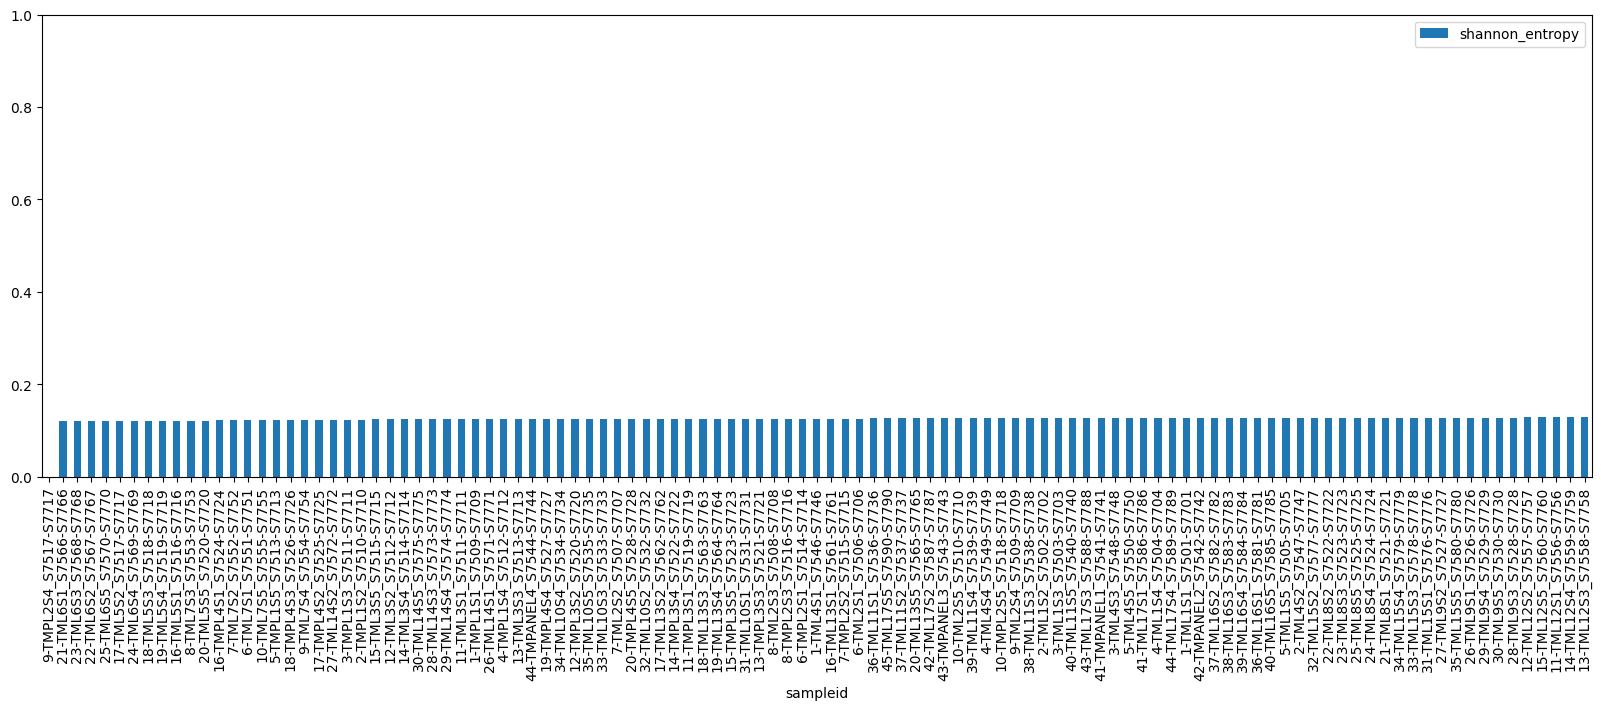

In [2]:

entropydf.sort_values(by="shannon_entropy", ascending=True, inplace=True)
entropydf.set_index("sampleid").plot.bar(figsize = (20,6))
plt.ylim([0, 1])


<Axes: xlabel='max_umi'>

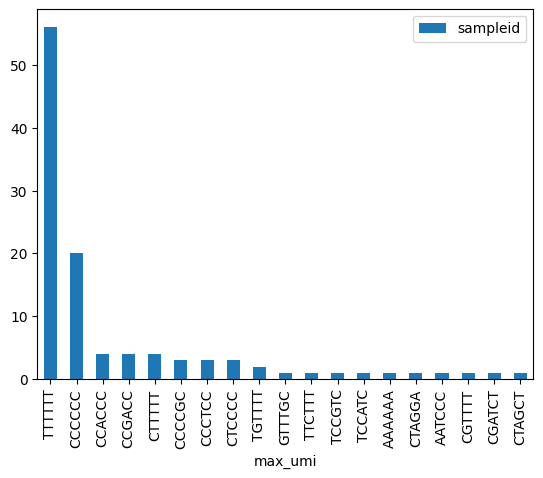

In [3]:
count_max_df = pd.DataFrame()
for sampleid in umidf.columns[1:]:
    max_umi = umidf[umidf[sampleid] == umidf[sampleid].max()]["umi"].values[0]
    top5_umi = umidf.sort_values(by=sampleid, ascending=False).head(5)
    tmpcount_max_df = pd.DataFrame({"sampleid": [sampleid], 
                                    "max_umi": [max_umi], 
                                    "max_5_umi": ",".join(sorted(top5_umi["umi"].to_list())),
                                    "max_count": [umidf[sampleid].max()],
                                    "max_pct": [umi_pct_df[f"pct_{sampleid}"].max()]})
    count_max_df = pd.concat([count_max_df, tmpcount_max_df], ignore_index=True)
count_max_df.groupby("max_umi")["sampleid"].count().sort_values(ascending=False).reset_index().plot.bar(x = "max_umi")


In [4]:
count_max_df.groupby("max_umi")["sampleid"].count().sort_values(ascending=False).reset_index()

,max_umi,sampleid
0,TTTTTT,56
1,CCCCCC,20
2,CCACCC,4
3,CCGACC,4
4,CTTTTT,4
5,CCCCGC,3
6,CCCTCC,3
7,CTCCCC,3
8,TGTTTT,2
9,GTTTGC,1


In [5]:
umi_pct_df.sort_values(by="pct_20-TML5S5_S7520-S7720", ascending=False, inplace=True)
umi_pct_df.head(10)

,umi,pct_18-TML13S3_S7563-S7763,pct_33-TML15S3_S7578-S7778,pct_11-TMPL3S1_S7519-S7719,pct_21-TML8S1_S7521-S7721,pct_44-TMPANEL4_S7544-S7744,pct_35-TML10S5_S7535-S7735,pct_26-TML9S1_S7526-S7726,pct_42-TML17S2_S7587-S7787,pct_7-TML7S2_S7552-S7752,...,pct_19-TML5S4_S7519-S7719,pct_17-TML13S2_S7562-S7762,pct_13-TML12S3_S7558-S7758,pct_5-TML4S5_S7550-S7750,pct_10-TML7S5_S7555-S7755,pct_6-TMPL2S1_S7514-S7714,pct_18-TMPL4S3_S7526-S7726,pct_4-TML4S4_S7549-S7749,pct_20-TML13S5_S7565-S7765,pct_38-TML16S3_S7583-S7783
4095,TTTTTT,0.172213,0.081363,0.195608,0.149657,0.161373,0.003838,0.116413,0.085612,0.160651,...,0.297064,0.101085,0.073856,0.072591,0.232456,0.144813,0.306697,0.081299,0.076543,0.055717
3327,TATTTT,0.089337,0.046193,0.073879,0.076798,0.079024,0.007356,0.068148,0.049200,0.060663,...,0.143142,0.063738,0.054020,0.042821,0.069557,0.062718,0.116409,0.046012,0.063177,0.036528
1023,ATTTTT,0.104930,0.038320,0.126561,0.085627,0.080642,0.007036,0.070273,0.061109,0.042068,...,0.133741,0.067864,0.042128,0.039272,0.049593,0.080055,0.108297,0.039666,0.067706,0.040690
4093,TTTTTC,0.102694,0.069378,0.103649,0.061426,0.101948,0.003198,0.062701,0.050957,0.062340,...,0.129557,0.081309,0.038228,0.048293,0.081363,0.088214,0.146881,0.048741,0.064930,0.042539
2047,CTTTTT,0.103626,0.065966,0.129678,0.075527,0.113726,0.051813,0.068475,0.071750,0.092062,...,0.115232,0.099520,0.047857,0.045647,0.091142,0.071387,0.161569,0.050074,0.106708,0.082997
4087,TTTTCT,0.092878,0.062291,0.092895,0.057424,0.101049,0.004798,0.068529,0.049786,0.054338,...,0.119269,0.076045,0.040009,0.042339,0.062903,0.060679,0.159596,0.050074,0.067267,0.033523
3583,TCTTTT,0.089772,0.060366,0.110351,0.068667,0.111928,0.030065,0.065915,0.044319,0.077658,...,0.124093,0.085506,0.045739,0.048354,0.086918,0.055580,0.153020,0.047980,0.076762,0.071900
4063,TTTCTT,0.091884,0.049256,0.095077,0.063077,0.099881,0.006077,0.058016,0.059938,0.095720,...,0.115479,0.079175,0.044535,0.036626,0.120424,0.053030,0.149073,0.038143,0.071431,0.046007
4092,TTTTTA,0.095363,0.042257,0.071541,0.070636,0.059605,0.003518,0.053876,0.046174,0.042144,...,0.119859,0.057905,0.037746,0.035062,0.050287,0.065268,0.098432,0.037318,0.040098,0.022657
4047,TTTATT,0.099277,0.032108,0.093050,0.058821,0.073540,0.001599,0.065479,0.052128,0.053042,...,0.118973,0.064094,0.051035,0.032717,0.070078,0.062718,0.099090,0.033192,0.055289,0.030517


In [6]:
count_max_df.groupby("max_5_umi")["sampleid"].count().sort_values(ascending=False).reset_index()

,max_5_umi,sampleid
0,"CCCCCC,CCCCTC,CCCTCC,CTCCCC,TCCCCC",5
1,"TCTTTT,TTCTTT,TTTCTT,TTTTTC,TTTTTT",4
2,"CCTCCC,CCTCCT,CCTCTC,CCTTCC,TTTTTT",4
3,"CCACCC,CCATCC,CCCCCC,GCACCC,TCACCC",3
4,"ATTTTT,TATTTT,TTTTTA,TTTTTC,TTTTTT",3
...,...,...
80,"CCCCCC,CCCCGC,CCCCGT,CCCCTC,CCTCGC",1
81,"CCCACC,CCCCCC,CCCCTC,CTCCCC,TCCCCC",1
82,"CCACCC,CCCCCC,GCACCC,TCACCC,TCCGTC",1
83,"CCACCC,CCCCCC,CCCCTC,CCTCCC,TCCCCC",1


<Axes: xlabel='umi'>

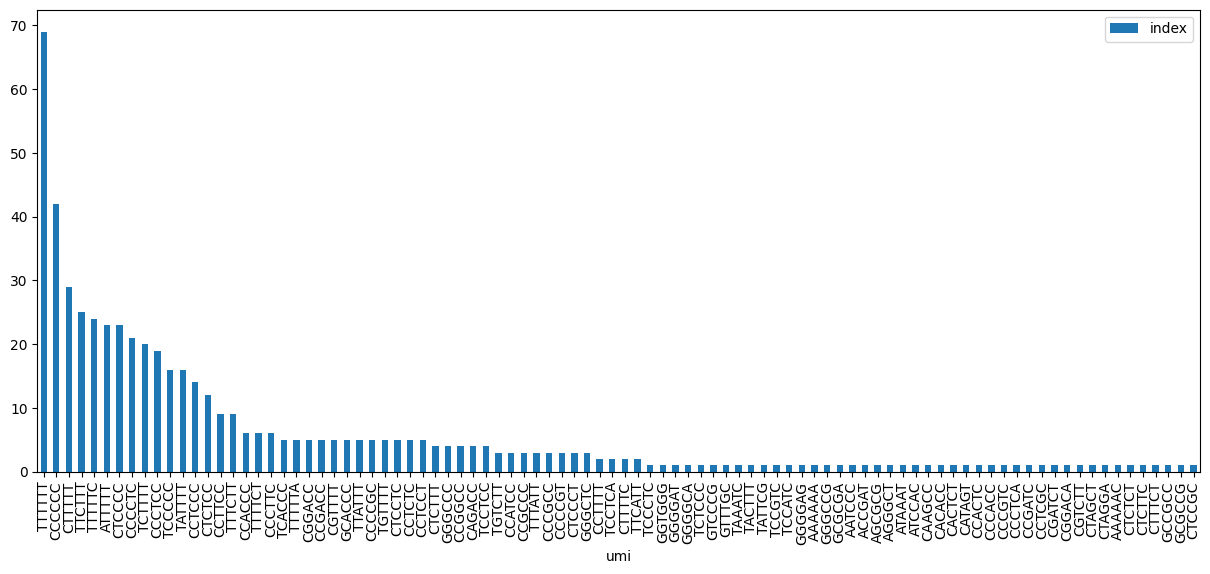

In [7]:
all_motifs = []
[[all_motifs.append(j) for j in item.split(",")] for item in count_max_df.max_5_umi.to_list()]
count_top5 = pd.DataFrame(data = all_motifs, columns =["umi"])
count_top5.reset_index().groupby("umi")["index"].count().sort_values(ascending=False).reset_index().plot.bar(figsize=(15, 6), x="umi", y="index")

In [8]:
len(set(all_motifs))

92

In [9]:
checkdf = umidf[["umi", "34-TML10S4_S7534-S7734"]].sort_values(by="34-TML10S4_S7534-S7734", ascending=False)
checkdf[checkdf["umi"] == "CTTGGC"]

,umi,34-TML10S4_S7534-S7734
2025,CTTGGC,42


In [10]:
checkdf

,umi,34-TML10S4_S7534-S7734
4095,TTTTTT,565
3903,TTATTT,401
3967,TTCTTT,382
3327,TATTTT,314
3919,TTCATT,284
...,...,...
335,ACCATT,8
1107,CACCAT,5
2131,GACCAT,4
3155,TACCAT,4


In [11]:
tmpdf = umidf[["umi", sampleid]].sort_values(by=sampleid, ascending=True)
tmpdf["accumsum"] = tmpdf[sampleid].cumsum()

In [12]:
from itertools import combinations

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

umi_counts = dict(zip(tmpdf['umi'], tmpdf[sampleid]))

merged = set()
new_umi_counts = {}

for umi in tmpdf['umi']:
    if umi in merged:
        continue
    # Find UMIs with hamming distance <= 1
    similar = [umi2 for umi2 in tmpdf['umi'] if umi2 != umi and hamming_distance(umi, umi2) <= 1]
    total_count = umi_counts[umi]
    for umi2 in similar:
        if umi2 not in merged:
            total_count += umi_counts[umi2]
            merged.add(umi2)
    new_umi_counts[umi] = total_count
    merged.add(umi)

combined_UMI = pd.DataFrame(list(new_umi_counts.items()), columns=['umi', sampleid]).sort_values(sampleid, ascending=False).reset_index(drop=True)

In [13]:
combined_UMI

,umi,38-TML16S3_S7583-S7783
0,TTATTA,1647
1,CGTGTA,1579
2,CGCACC,1559
3,CACATG,1384
4,TCGTGT,1348
...,...,...
688,CCGGTA,120
689,CGTGAC,116
690,CTGGCC,115
691,GGGTCA,98


<Axes: >

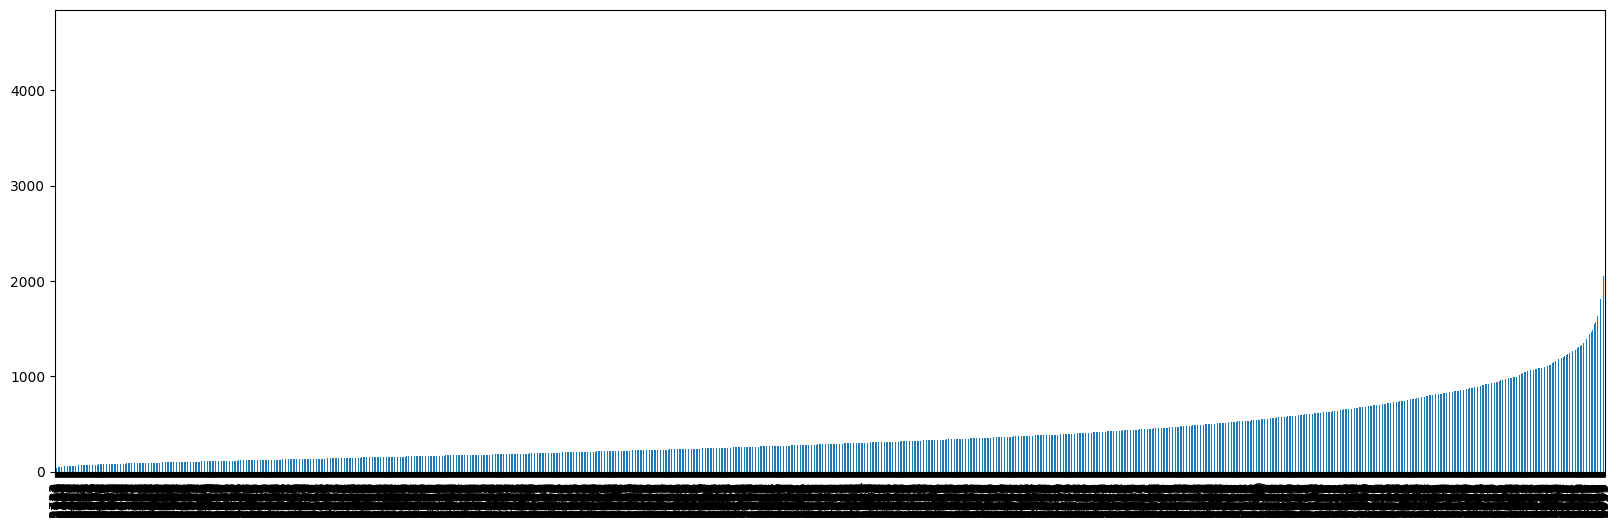

In [14]:
umidf.sort_values(by = "20-TML5S5_S7520-S7720")["20-TML5S5_S7520-S7720"].plot.bar(figsize=(20,6))